# SimCLR

 参考文献  
- 元論文：https://arxiv.org/pdf/2002.05709.pdf  
- 実装記事：  
  - https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7
  - https://github.com/sthalles/SimCLR  
- 日本語記事：https://qiita.com/DeepTama/items/c63f5087f4c1aabccddf
- 参考記事：https://qiita.com/sugulu_Ogawa_ISID/items/e3c01a0776a5df3ad552

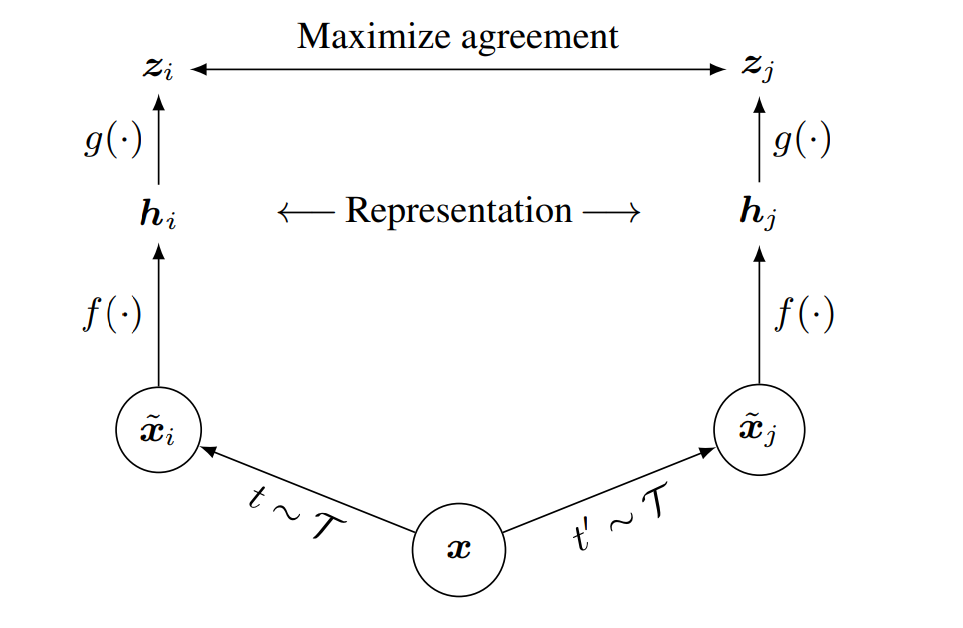

### 3-1 初期設定

In [ ]:
# ライブラリのインポート
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from tqdm import tqdm

In [ ]:
# deviceの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 3-2 データ拡張 

データセットはstl10を用いるつもりだったが、重いのでCIFAR10にした。
> sifar10とは
- スタンフォード大学が公開している10クラスの画像データセット
- 学習用データ、テスト用データ、ラベルなしデータがある
- 学習用データは1クラスにつき500枚
- テストデータは1クラスにつき800枚
- ラベルなしデータは10万枚ある
- 96 * 96 ピクセル

Data Augmentationでは、
1. ランダムなクロッピング(random cropping)  
2. ランダムな色の歪み(random color distortions)  
3. ガウシアンぼかし(random Gaussian blur)  

を連続的に適用する。  
データ x を x_tilde に変換する。


> 画像処理において、ガウシアンぼかし とは、ガウス関数をもちいて画像をぼかす処理である。デジタルカメラの撮像画像などからノイズを除去したり、アンシャープマスク処理、エッジ抽出の前処理などに応用できる。



In [ ]:
# ガウシアンぼかしの実装
class GaussianBlur(object):
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [ ]:
# x から x_tilde_i (i = 1,...,n_view) の組を作る
class ContrastiveLearningViewGenerator(object):

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

In [ ]:
class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        # x から x_tilde への変換を定義
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s) # ランダムに明るさ、コントラスト、彩度、色相を変化させる
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size), # ランダムなクロッピング
                                              transforms.RandomHorizontalFlip(), # ランダムな左右反転
                                              transforms.RandomApply([color_jitter], p=0.8), # ランダムな色の歪み(ランダムに color_jitter を適応する)
                                              transforms.RandomGrayscale(p=0.2), # 同上(グレースケール化)
                                              GaussianBlur(kernel_size=int(0.1 * size)), # ガウシアンぼかし
                                              transforms.ToTensor()])
        return data_transforms

    def get_dataset(self, n_views=2, train=True): 
        '''
        STL10 の場合、三つ目の引数は split (デフォルトは'unlabeled')
        Args:
            split (string): One of {'train', 'test', 'unlabeled', 'train+unlabeled'}.
                Accordingly dataset is selected.
        '''
        '''
        dataset_fn = datasets.STL10(self.root_folder, split,
                                    transform=ContrastiveLearningViewGenerator(
                                        self.get_simclr_pipeline_transform(96),
                                        n_views),
                                    download=True)
        '''
        dataset_fn = datasets.CIFAR10(self.root_folder, train,
                                      transform=ContrastiveLearningViewGenerator(
                                          self.get_simclr_pipeline_transform(32),
                                          n_views),
                                      download=True)
        return dataset_fn

### 3-3 モデル

1. エンコーダー（バックボーンとも） f(·) の実装。変換されたデータ x_tilde から、特徴表現 h を得る。エンコーダーにはResNetを使用する。
2. 非線形投影 g(·) は特徴表現 h から z に変換。隠れ層が一つのMLPを用いる。エンコーダーの最終層にこの非線形投影を追加し、モデルを構築。

参考：resnet18
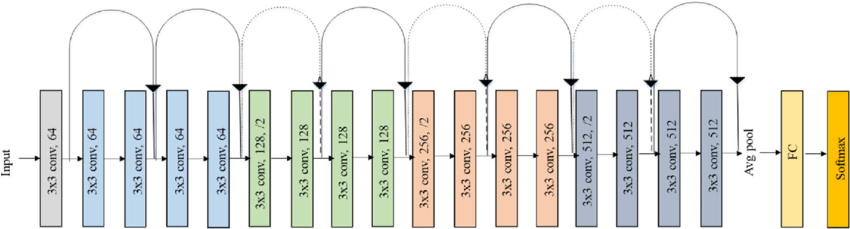

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features # 入力の次元(in_features と書くことが多い)
        self.out_features = out_features # 出力の次元
        self.hidden_features = hidden_features # 隠れ層の次元
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features, self.out_features, False, True)
        elif self.head_type == 'nonlinear': # 非線形投影
            self.layers = nn.Sequential(
                LinearLayer(self.in_features, self.hidden_features, True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features, self.out_features, False, True))
        
    def forward(self,x_tilde):
        h = self.layers(x_tilde)
        return h

class PreModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # エンコーダー
        self.pretrained = models.resnet18(pretrained=True)
        # self.pretrained = models.resnet50(pretrained=True)
        
        # resnetの各層を編集
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False) 
        self.pretrained.maxpool = Identity()
        self.dim_mlp = self.pretrained.fc.in_features
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True # パラメタは固定しない
        
        self.projector = ProjectionHead(self.dim_mlp, 2048, 128)

    def forward(self,x_tilde):
        h = self.pretrained(x_tilde)
        
        z = self.projector(torch.squeeze(h))
        
        return z

### 3-4 損失関数
contrastive loss function  
zi と zj の照合タスクのための損失関数。

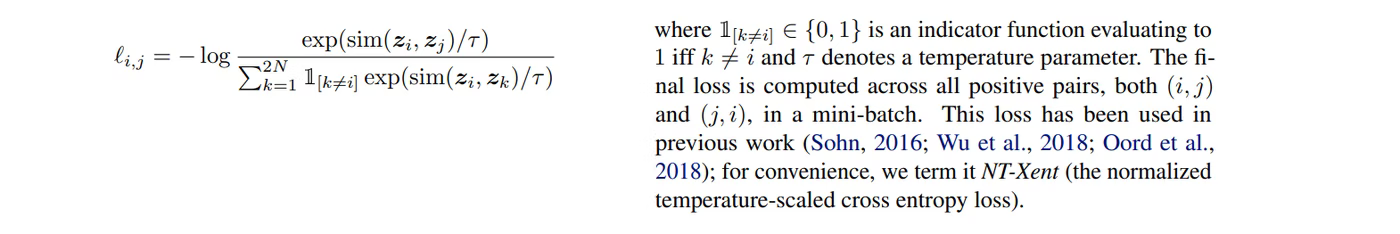
sim(u, v)：uとvの間のコサイン類似度  

In [ ]:
class SimCLRLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLRLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size): # 同じデータ x から生成された z (z_i, z_j) に対する処理
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0))/ self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1) # shape:(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1) # shape:(N, N-2)
        
        # positive_samples.device：positive_samples がいる device
        # [0]*N：N行すべての予測(ここでは類似度)に対して、正解ラベルを第一列に設定
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1) # shape(N, N-1)、第一列に positive の sim が並ぶ

        # CrossEntropyLossとcontrastive loss functionは以下の記事を読むと繋がる
        # https://qiita.com/ground0state/items/8933f9ef54d6cd005a69
        loss = self.criterion(logits, labels)/ N
        
        return loss

#### コラム  

unsqueeze の使い方を知る

In [ ]:
def main(n, len_h):
  mat = torch.randn(n, len_h)
  print(mat)
  mat_uns_1 = mat.unsqueeze(1)
  print(mat_uns_1)
  mat_uns_0 = mat.unsqueeze(0)
  print(mat_uns_0)

main(n=3, len_h=4)

tensor([[ 0.8733, -1.9181,  2.3618,  0.7667],
        [-1.1015,  1.0883, -2.5474, -0.0752],
        [ 0.8345, -0.4902, -0.4585,  2.5902]])
tensor([[[ 0.8733, -1.9181,  2.3618,  0.7667]],

        [[-1.1015,  1.0883, -2.5474, -0.0752]],

        [[ 0.8345, -0.4902, -0.4585,  2.5902]]])
tensor([[[ 0.8733, -1.9181,  2.3618,  0.7667],
         [-1.1015,  1.0883, -2.5474, -0.0752],
         [ 0.8345, -0.4902, -0.4585,  2.5902]]])


torch.diag の使い方を知る

In [ ]:
def main(n):
  mat = torch.randn((n*2, n*2))
  print(mat)
  mat_diag = torch.diag(mat,n)
  print(mat_diag)
  mat_diag_minus = torch.diag(mat,-n)
  print(mat_diag_minus)

main(n=3)

tensor([[-0.4458,  0.3003, -0.8607,  0.3994, -0.3378, -0.3403],
        [ 1.3429, -0.1818,  0.6516, -0.1859,  0.2768,  0.0776],
        [-0.7601,  1.2256, -0.8834,  0.5402, -2.8425,  0.8661],
        [-1.0046,  1.4431,  0.2095,  2.0700, -0.9988,  1.3677],
        [-1.3596,  0.2423, -1.7982,  0.0426,  1.7867,  1.5749],
        [-0.9952, -0.6148, -1.4153, -0.2069,  0.5044,  0.9680]])
tensor([0.3994, 0.2768, 0.8661])
tensor([-1.0046,  0.2423, -1.4153])


### 3-5 Optimizer
Optimizerには、LARS（Layer-wise Adaptive Rate Scaling）を用いる。


参考  
日本語記事：https://qiita.com/takoroy/items/96bd92abe5a50d16a018  
実装：https://github.com/Spijkervet/SimCLR  



In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

### 3-6 学習

#### データローダーの定義

In [ ]:
# DATALOADER
batch_size = 100

dataset = ContrastiveLearningDataset('./data')

train_dataset = dataset.get_dataset()

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

valid_dataset = dataset.get_dataset(train=False)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


##### データ変換の挙動

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


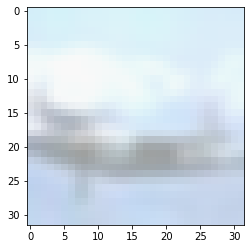

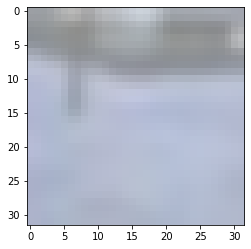

In [ ]:
# 変換後画像 x_tilde の表示
def imshow(img):
    img = img / 2 + 0.5 # 非正規化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, _ = next(iter(train_loader)) # images の shape：(n_views=2,batch_size)
imshow(torchvision.utils.make_grid(images[0][0]))
imshow(torchvision.utils.make_grid(images[1][0]))

#### そのほかの定義

In [ ]:
# MODEL
model = PreModel().to(device)

# OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.1, # = 0.3 × BatchSize/256
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

# SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

# LOSS FUNCTION
criterion = SimCLRLoss(batch_size = 100, temperature = 0.1)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch     0: adjusting learning rate of group 0 to 1.0000e-01.


#### 学習

In [ ]:
# 学習
epochs = 100

tr_loss_list = []
val_loss_list = []

for epoch in range(1, epochs+1):
        
    print(f"Epoch [{epoch}/{epochs}]\t")

    tr_losses = []
    val_losses = []

    model.train()
    for images, _ in tqdm(train_loader):
        optimizer.zero_grad()
        x_tilde_i, x_tilde_j = images[0], images[1] 

        x_tilde_i = x_tilde_i.to(device).float()
        x_tilde_j = x_tilde_j.to(device).float()

        # モデルにより x_tilde を z に変換
        z_i = model(x_tilde_i)
        z_j = model(x_tilde_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        tr_losses.append(loss.cpu().detach().numpy())

    tr_loss_tmp = np.average(tr_losses)
    tr_loss_list.append(tr_loss_tmp)
    print("EPOCH: {} train_loss: {}".format(epoch, tr_loss_tmp))

    if epoch < 10:
        warmupscheduler.step()
    if epoch >= 10:
        mainscheduler.step()

'''
    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(valid_loader):
        
            x_tilde_i, x_tilde_j = images[0], images[1] 
            x_tilde_i = x_tilde_i.to(device).float()
            x_tilde_j = x_tilde_j.to(device).float()

            z_i = model(x_tilde_i)
            z_j = model(x_tilde_j)

            loss = criterion(z_i, z_j)

            val_losses.append(loss.cpu().detach().numpy())

        val_loss_tmp = np.average(val_losses)
        val_loss_list.append(val_loss_tmp)
    print("EPOCH: {} val_loss: {}".format(epoch, val_loss_tmp))
'''

Epoch [0/100]	


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


EPOCH: 0 loss: 4.605171203613281
Adjusting learning rate of group 0 to 2.0000e-02.
Epoch [1/100]	


100%|██████████| 500/500 [02:45<00:00,  3.02it/s]


EPOCH: 1 loss: 3.5446674823760986
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch [2/100]	


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


EPOCH: 2 loss: 3.2275185585021973
Adjusting learning rate of group 0 to 4.0000e-02.
Epoch [3/100]	


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


EPOCH: 3 loss: 2.9352004528045654
Adjusting learning rate of group 0 to 5.0000e-02.
Epoch [4/100]	


100%|██████████| 500/500 [02:43<00:00,  3.07it/s]


EPOCH: 4 loss: 2.6398661136627197
Adjusting learning rate of group 0 to 6.0000e-02.
Epoch [5/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 5 loss: 2.4112138748168945
Adjusting learning rate of group 0 to 7.0000e-02.
Epoch [6/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 6 loss: 2.2227838039398193
Adjusting learning rate of group 0 to 8.0000e-02.
Epoch [7/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 7 loss: 2.0687642097473145
Adjusting learning rate of group 0 to 9.0000e-02.
Epoch [8/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 8 loss: 1.9502618312835693
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch [9/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 9 loss: 1.8409156799316406
Adjusting learning rate of group 0 to 1.1000e-01.
Epoch [10/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 10 loss: 1.7605851888656616
Epoch     1: adjusting learning rate of group 0 to 1.0000e-01.
Epoch [11/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 11 loss: 1.667421817779541
Epoch     2: adjusting learning rate of group 0 to 9.9998e-02.
Epoch [12/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 12 loss: 1.6301860809326172
Epoch     3: adjusting learning rate of group 0 to 9.9996e-02.
Epoch [13/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 13 loss: 1.5839022397994995
Epoch     4: adjusting learning rate of group 0 to 9.9992e-02.
Epoch [14/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 14 loss: 1.5354634523391724
Epoch     5: adjusting learning rate of group 0 to 9.9988e-02.
Epoch [15/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 15 loss: 1.5108295679092407
Epoch     6: adjusting learning rate of group 0 to 9.9982e-02.
Epoch [16/100]	


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


EPOCH: 16 loss: 1.4802385568618774
Epoch     7: adjusting learning rate of group 0 to 9.9976e-02.
Epoch [17/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 17 loss: 1.4318301677703857
Epoch     8: adjusting learning rate of group 0 to 9.9968e-02.
Epoch [18/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 18 loss: 1.4212558269500732
Epoch     9: adjusting learning rate of group 0 to 9.9960e-02.
Epoch [19/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 19 loss: 1.4057356119155884
Epoch    10: adjusting learning rate of group 0 to 9.9951e-02.
Epoch [20/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 20 loss: 1.380391001701355
Epoch    11: adjusting learning rate of group 0 to 9.9940e-02.
Epoch [21/100]	


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


EPOCH: 21 loss: 1.3605505228042603
Epoch    12: adjusting learning rate of group 0 to 9.9929e-02.
Epoch [22/100]	


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


EPOCH: 22 loss: 1.3411650657653809
Epoch    13: adjusting learning rate of group 0 to 9.9917e-02.
Epoch [23/100]	


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


EPOCH: 23 loss: 1.3274294137954712
Epoch    14: adjusting learning rate of group 0 to 9.9903e-02.
Epoch [24/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 24 loss: 1.3151191473007202
Epoch    15: adjusting learning rate of group 0 to 9.9889e-02.
Epoch [25/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 25 loss: 1.2918373346328735
Epoch    16: adjusting learning rate of group 0 to 9.9874e-02.
Epoch [26/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 26 loss: 1.2838391065597534
Epoch    17: adjusting learning rate of group 0 to 9.9858e-02.
Epoch [27/100]	


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


EPOCH: 27 loss: 1.2833489179611206
Epoch    18: adjusting learning rate of group 0 to 9.9840e-02.
Epoch [28/100]	


100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


EPOCH: 28 loss: 1.2589081525802612
Epoch    19: adjusting learning rate of group 0 to 9.9822e-02.
Epoch [29/100]	


100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


EPOCH: 29 loss: 1.2489111423492432
Epoch    20: adjusting learning rate of group 0 to 9.9803e-02.
Epoch [30/100]	


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


EPOCH: 30 loss: 1.2365808486938477
Epoch    21: adjusting learning rate of group 0 to 9.9783e-02.
Epoch [31/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 31 loss: 1.2331279516220093
Epoch    22: adjusting learning rate of group 0 to 9.9762e-02.
Epoch [32/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 32 loss: 1.2201908826828003
Epoch    23: adjusting learning rate of group 0 to 9.9739e-02.
Epoch [33/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 33 loss: 1.2151931524276733
Epoch    24: adjusting learning rate of group 0 to 9.9716e-02.
Epoch [34/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 34 loss: 1.2059664726257324
Epoch    25: adjusting learning rate of group 0 to 9.9692e-02.
Epoch [35/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 35 loss: 1.1969259977340698
Epoch    26: adjusting learning rate of group 0 to 9.9667e-02.
Epoch [36/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 36 loss: 1.1810375452041626
Epoch    27: adjusting learning rate of group 0 to 9.9641e-02.
Epoch [37/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 37 loss: 1.1590169668197632
Epoch    28: adjusting learning rate of group 0 to 9.9614e-02.
Epoch [38/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 38 loss: 1.1683241128921509
Epoch    29: adjusting learning rate of group 0 to 9.9586e-02.
Epoch [39/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 39 loss: 1.1414082050323486
Epoch    30: adjusting learning rate of group 0 to 9.9557e-02.
Epoch [40/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 40 loss: 1.1622270345687866
Epoch    31: adjusting learning rate of group 0 to 9.9527e-02.
Epoch [41/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 41 loss: 1.1409295797348022
Epoch    32: adjusting learning rate of group 0 to 9.9496e-02.
Epoch [42/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 42 loss: 1.1449445486068726
Epoch    33: adjusting learning rate of group 0 to 9.9465e-02.
Epoch [43/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 43 loss: 1.1249464750289917
Epoch    34: adjusting learning rate of group 0 to 9.9432e-02.
Epoch [44/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 44 loss: 1.1230778694152832
Epoch    35: adjusting learning rate of group 0 to 9.9398e-02.
Epoch [45/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 45 loss: 1.1166919469833374
Epoch    36: adjusting learning rate of group 0 to 9.9363e-02.
Epoch [46/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 46 loss: 1.1183173656463623
Epoch    37: adjusting learning rate of group 0 to 9.9327e-02.
Epoch [47/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 47 loss: 1.1018116474151611
Epoch    38: adjusting learning rate of group 0 to 9.9291e-02.
Epoch [48/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 48 loss: 1.1021616458892822
Epoch    39: adjusting learning rate of group 0 to 9.9253e-02.
Epoch [49/100]	


100%|██████████| 500/500 [02:48<00:00,  2.98it/s]


EPOCH: 49 loss: 1.0989335775375366
Epoch    40: adjusting learning rate of group 0 to 9.9215e-02.
Epoch [50/100]	


100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


EPOCH: 50 loss: 1.0933047533035278
Epoch    41: adjusting learning rate of group 0 to 9.9175e-02.
Epoch [51/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 51 loss: 1.0828430652618408
Epoch    42: adjusting learning rate of group 0 to 9.9135e-02.
Epoch [52/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 52 loss: 1.0858910083770752
Epoch    43: adjusting learning rate of group 0 to 9.9093e-02.
Epoch [53/100]	


100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


EPOCH: 53 loss: 1.0779536962509155
Epoch    44: adjusting learning rate of group 0 to 9.9051e-02.
Epoch [54/100]	


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


EPOCH: 54 loss: 1.0807583332061768
Epoch    45: adjusting learning rate of group 0 to 9.9007e-02.
Epoch [55/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 55 loss: 1.0740034580230713
Epoch    46: adjusting learning rate of group 0 to 9.8963e-02.
Epoch [56/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 56 loss: 1.0658494234085083
Epoch    47: adjusting learning rate of group 0 to 9.8918e-02.
Epoch [57/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 57 loss: 1.0620713233947754
Epoch    48: adjusting learning rate of group 0 to 9.8872e-02.
Epoch [58/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 58 loss: 1.0632050037384033
Epoch    49: adjusting learning rate of group 0 to 9.8824e-02.
Epoch [59/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 59 loss: 1.057186484336853
Epoch    50: adjusting learning rate of group 0 to 9.8776e-02.
Epoch [60/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 60 loss: 1.057710886001587
Epoch    51: adjusting learning rate of group 0 to 9.8727e-02.
Epoch [61/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 61 loss: 1.0433197021484375
Epoch    52: adjusting learning rate of group 0 to 9.8677e-02.
Epoch [62/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 62 loss: 1.0391030311584473
Epoch    53: adjusting learning rate of group 0 to 9.8627e-02.
Epoch [63/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 63 loss: 1.0441899299621582
Epoch    54: adjusting learning rate of group 0 to 9.8575e-02.
Epoch [64/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 64 loss: 1.0399037599563599
Epoch    55: adjusting learning rate of group 0 to 9.8522e-02.
Epoch [65/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 65 loss: 1.0415982007980347
Epoch    56: adjusting learning rate of group 0 to 9.8468e-02.
Epoch [66/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 66 loss: 1.0332435369491577
Epoch    57: adjusting learning rate of group 0 to 9.8414e-02.
Epoch [67/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 67 loss: 1.0346870422363281
Epoch    58: adjusting learning rate of group 0 to 9.8358e-02.
Epoch [68/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 68 loss: 1.023341178894043
Epoch    59: adjusting learning rate of group 0 to 9.8302e-02.
Epoch [69/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 69 loss: 1.0226956605911255
Epoch    60: adjusting learning rate of group 0 to 9.8244e-02.
Epoch [70/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 70 loss: 1.0111987590789795
Epoch    61: adjusting learning rate of group 0 to 9.8186e-02.
Epoch [71/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 71 loss: 0.9986909627914429
Epoch    62: adjusting learning rate of group 0 to 9.8127e-02.
Epoch [72/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 72 loss: 1.0128334760665894
Epoch    63: adjusting learning rate of group 0 to 9.8067e-02.
Epoch [73/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 73 loss: 1.0108598470687866
Epoch    64: adjusting learning rate of group 0 to 9.8006e-02.
Epoch [74/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 74 loss: 1.0033483505249023
Epoch    65: adjusting learning rate of group 0 to 9.7944e-02.
Epoch [75/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 75 loss: 1.0058104991912842
Epoch    66: adjusting learning rate of group 0 to 9.7881e-02.
Epoch [76/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 76 loss: 0.9938291311264038
Epoch    67: adjusting learning rate of group 0 to 9.7817e-02.
Epoch [77/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 77 loss: 1.0002050399780273
Epoch    68: adjusting learning rate of group 0 to 9.7753e-02.
Epoch [78/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 78 loss: 0.9949893951416016
Epoch    69: adjusting learning rate of group 0 to 9.7687e-02.
Epoch [79/100]	


100%|██████████| 500/500 [03:11<00:00,  2.61it/s]


EPOCH: 79 loss: 0.9902014136314392
Epoch    70: adjusting learning rate of group 0 to 9.7621e-02.
Epoch [80/100]	


100%|██████████| 500/500 [02:55<00:00,  2.84it/s]


EPOCH: 80 loss: 0.9919588565826416
Epoch    71: adjusting learning rate of group 0 to 9.7553e-02.
Epoch [81/100]	


100%|██████████| 500/500 [02:43<00:00,  3.07it/s]


EPOCH: 81 loss: 0.9898883104324341
Epoch    72: adjusting learning rate of group 0 to 9.7485e-02.
Epoch [82/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 82 loss: 0.9848257899284363
Epoch    73: adjusting learning rate of group 0 to 9.7416e-02.
Epoch [83/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 83 loss: 0.9869254231452942
Epoch    74: adjusting learning rate of group 0 to 9.7346e-02.
Epoch [84/100]	


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


EPOCH: 84 loss: 0.9876546859741211
Epoch    75: adjusting learning rate of group 0 to 9.7275e-02.
Epoch [85/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 85 loss: 0.9729183316230774
Epoch    76: adjusting learning rate of group 0 to 9.7203e-02.
Epoch [86/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 86 loss: 0.9688032269477844
Epoch    77: adjusting learning rate of group 0 to 9.7131e-02.
Epoch [87/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 87 loss: 0.9651678204536438
Epoch    78: adjusting learning rate of group 0 to 9.7057e-02.
Epoch [88/100]	


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


EPOCH: 88 loss: 0.9734100103378296
Epoch    79: adjusting learning rate of group 0 to 9.6983e-02.
Epoch [89/100]	


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


EPOCH: 89 loss: 0.9831287860870361
Epoch    80: adjusting learning rate of group 0 to 9.6908e-02.
Epoch [90/100]	


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


EPOCH: 90 loss: 0.970691442489624
Epoch    81: adjusting learning rate of group 0 to 9.6832e-02.
Epoch [91/100]	


100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


EPOCH: 91 loss: 0.9608494639396667
Epoch    82: adjusting learning rate of group 0 to 9.6755e-02.
Epoch [92/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 92 loss: 0.9472864866256714
Epoch    83: adjusting learning rate of group 0 to 9.6677e-02.
Epoch [93/100]	


100%|██████████| 500/500 [02:42<00:00,  3.09it/s]


EPOCH: 93 loss: 0.9487512707710266
Epoch    84: adjusting learning rate of group 0 to 9.6598e-02.
Epoch [94/100]	


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


EPOCH: 94 loss: 0.9689961671829224
Epoch    85: adjusting learning rate of group 0 to 9.6519e-02.
Epoch [95/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 95 loss: 0.9613463282585144
Epoch    86: adjusting learning rate of group 0 to 9.6438e-02.
Epoch [96/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 96 loss: 0.9535911083221436
Epoch    87: adjusting learning rate of group 0 to 9.6357e-02.
Epoch [97/100]	


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


EPOCH: 97 loss: 0.9504410624504089
Epoch    88: adjusting learning rate of group 0 to 9.6275e-02.
Epoch [98/100]	


100%|██████████| 500/500 [02:41<00:00,  3.10it/s]


EPOCH: 98 loss: 0.9438732862472534
Epoch    89: adjusting learning rate of group 0 to 9.6192e-02.
Epoch [99/100]	


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]

EPOCH: 99 loss: 0.9377762675285339
Epoch    90: adjusting learning rate of group 0 to 9.6108e-02.


'\n    model.eval()\n    with torch.no_grad():\n        val_loss_epoch = 0\n        for images, _ in valid_loader:\n        \n          x_tilde_i, x_tilde_j = images[0], images[1] \n          x_tilde_i = x_tilde_i.to(device).float()\n          x_tilde_j = x_tilde_j.to(device).float()\n\n          z_i = model(x_tilde_i)\n          z_j = model(x_tilde_j)\n\n          loss = criterion(z_i, z_j)\n\n          val_losses.append(loss.cpu().detach().numpy())\n\n    val_loss_tmp = np.average(val_losses)\n    val_loss_list.append(val_loss_tmp)\n    if epoch % 10 == 0:\n        print("EPOCH: {} loss: {}".format(epoch, val_loss_tmp))\n'

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


val_loss: 1.0245227813720703


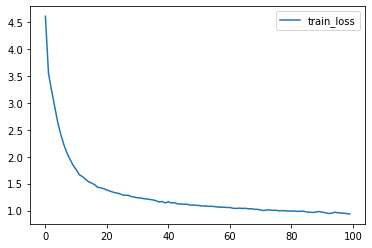

In [ ]:
# 結果
epoch_axis = np.arange(epochs)

plt.plot(epoch_axis, tr_loss_list, label="train_loss")
# plt.plot(epoch_axis, val_loss_list, label="val_loss")
plt.legend()

# 学習のセルのコメントアウトと、このセルの上のコメントアウトを解除して実行するならば、以下は不要なので消す。
model.eval()
with torch.no_grad():
    val_losses = []

    for images, _ in tqdm(valid_loader):
    
      x_tilde_i, x_tilde_j = images[0], images[1] 
      x_tilde_i = x_tilde_i.to(device).float()
      x_tilde_j = x_tilde_j.to(device).float()

      z_i = model(x_tilde_i)
      z_j = model(x_tilde_j)

      loss = criterion(z_i, z_j)

      val_losses.append(loss.cpu().detach().numpy())

val_loss_tmp = np.average(val_losses)
print("val_loss: {}".format(val_loss_tmp))

In [ ]:
# 学習後 accuracy の算出

similarity_f = nn.CosineSimilarity(dim=2)

N = 2 * batch_size
mask = torch.ones((N, N), dtype=bool)
mask = mask.fill_diagonal_(0)
        
for i in range(batch_size):
    mask[i, batch_size + i] = 0
    mask[batch_size + i, i] = 0

model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in tqdm(valid_loader):

      total += N
    
      x_tilde_i, x_tilde_j = images[0], images[1] 
      x_tilde_i = x_tilde_i.to(device).float()
      x_tilde_j = x_tilde_j.to(device).float()

      z_i = model(x_tilde_i)
      z_j = model(x_tilde_j)

      z = torch.cat((z_i, z_j), dim=0)

      sim = similarity_f(z.unsqueeze(1), z.unsqueeze(0))

      sim_i_j = torch.diag(sim, batch_size)
      sim_j_i = torch.diag(sim, -batch_size)
        
      positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1) # shape:(N, 1)
      negative_samples = sim[mask].reshape(N, -1) # shape:(N, N-2)
      
      predict = torch.argmax(torch.cat((positive_samples, negative_samples), dim=1), dim=1)

      cor = torch.sum(predict == 0) # predict == 0：x_tilde_i との類似度が最も高いものは x_tilde_j だと予測した

      correct += cor.cpu().detach().numpy()

    accuracy = correct/ total

print("val_accuracy: {}".format(accuracy))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:22<00:00,  4.36it/s]

val_accuracy: 0.8224


##### 実験

In [ ]:
def main():
  vec1 = torch.tensor([2,1,2])
  vec2 = torch.tensor([2,2,2])
  print(torch.sum(vec1 == vec2))

main()

tensor(2)


### 3-7 特徴抽出の結果

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


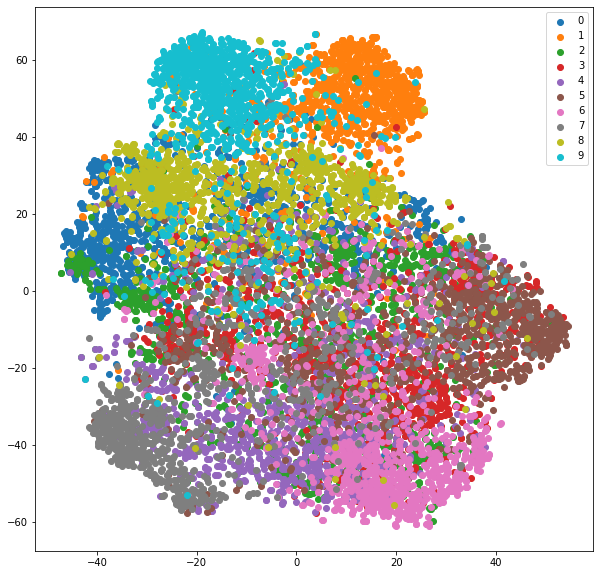

In [ ]:
num_features = model.dim_mlp # 特徴抽出機として用いるときは z ではなく h を用いる
num_classes = 10

h_list = np.array([]).reshape((0, num_features))
label_list = np.array([]).reshape((0))

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        x_tilde_i = images[0]
        x_tilde_i = x_tilde_i.to(device).float()

        # モデルにより表現 z を獲得
        h_i = model.pretrained(x_tilde_i)

        h_i = h_i.cpu().data.numpy()
        h_list = np.append(h_list, h_i, axis = 0)

        label_list = np.append(label_list, labels, axis = 0)

tsne = TSNE(n_components = 2, perplexity = 50)
x_feats = tsne.fit_transform(h_list)

plt.figure(figsize=(10,10))
for i in range(num_classes):
    plt.scatter(x_feats[label_list==i,1],x_feats[label_list==i,0])
plt.legend([str(i) for i in range(num_classes)])
plt.show()

### 3-8 モデルの重みの保存/読み込み

In [ ]:
# 重みの保存
torch.save(model.state_dict(), './SimCRL_sifar10.pth')

In [ ]:
# 新しいモデル
model = PreModel().to(device)

# 保存したモデルパラメータの読み込み
model.load_state_dict(torch.load('SimCRL_sifar10.pth'))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>